# Text Classification, Lab 2: Building a model with K-Train

## ⚡️ Make a Copy

Save a copy of this notebook in your Google Drive before continuing. Be sure to edit your own copy, not the original notebook.

## About this lab

The first part of this lab is identical to Lab 1, and you should be able to step through it easily.

We continue now with the goal of building an inference model for predicting whether or not a document is about "healthy living." We will use the K-Train library to do this.

## About the final project


Recall that you are working toward a final project. After completing this lab, you will want to go the extra mile and explore ways to tweak and improve your model. See the final project description for further details on what is expected.

## Imports

We're going to be using Google's Tensorflow package:
https://www.tensorflow.org/tutorials

We're using an API wrapper for Tensorflow called ktrain. It's absolutely fabulous because it really abstracts the whole deep learning process into a workflow so easy, even a computational social scientist can do it:
https://github.com/amaiya/ktrain

In [ ]:
# ORIGNAL PACKAGES BUT DON'T USE!
# import os
# try:
#   import ktrain
# except:
#   !pip install ktrain
#   os.kill(os.getpid(), 9)
# import ktrain
# import pandas as pd
# import numpy as np

In [1]:
import os
from sklearn.model_selection import train_test_split
!pip install tf-keras
print("TF_USE_LEGACY_KERAS:", os.getenv("TF_USE_LEGACY_KERAS"))
os.environ['TF_USE_LEGACY_KERAS'] = '1'
print("TF_USE_LEGACY_KERAS:", os.getenv("TF_USE_LEGACY_KERAS"))

try:
  import ktrain
except:
  !pip install ktrain
  import ktrain
from ktrain import text
from ktrain.text import texts_from_df

import pandas as pd
import numpy as np

TF_USE_LEGACY_KERAS: None
TF_USE_LEGACY_KERAS: 1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 33.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 50.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.41.3-py3-none-any.whl size=25316960 sha256=b9c2bbd7b596e75d5c102d0385e4bfd30444eee2e4070ea0695f9ec7b42faf0e
  Stored in directory: /root/.cache/pip/wheels/fc/76/11/5b953090eebf531f660948a30cd26e70260619f6480

## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set your google colab runtime to use GPU, a must for deep learning!

Runtime > Change Runtime Type > GPU

The following code snippet will show you GPU information for your runtime.

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 15 14:35:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load the data

The data file should be in your Google Drive from Lab 1.

In [4]:
reviews = pd.read_json("drive/MyDrive/news_category_trainingdata.json")

## Inspect the data

In [5]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


## Prepare the data

Most machine learning tools in Python accept one field/column/string. So we have to merge our two text column. Let's separate it with a space.

In [6]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

The first thing we need to do is prepare the data. Specifically, we have a categorical column that we want to turn into a "is this article healthy living?" column. That is, when an article is about healthy living, it should have a 1, when it's anything else, it should be a 0.

In [7]:
reviews[reviews['category'].str.contains("WELLNESS")]

,category,headline,authors,link,short_description,date,combined_text
124989,WELLNESS,Why Overeating Doesn't Make You Fat,"Mark Hyman, MD, Contributor\nPracticing Physician",https://www.huffingtonpost.com/entry/overeatin...,If you take the right approach to ending your ...,2014-04-17,Why Overeating Doesn't Make You Fat If you tak...
124990,WELLNESS,14 Habits Of People With A Healthy Relationshi...,Sarah Klein,https://www.huffingtonpost.com/entry/healthy-r...,After a long list of rules and habits like the...,2014-04-17,14 Habits Of People With A Healthy Relationshi...
124993,WELLNESS,5 Things That Could Be Stealing Your Joy,"Amanda Gore, Contributor\nInternational keynot...",https://www.huffingtonpost.com/entry/joy_us_5b...,Listen to yourself all day today -- are you an...,2014-04-17,5 Things That Could Be Stealing Your Joy Liste...
124994,WELLNESS,Moments Make a Life,"Megan McDonough, Contributor\nCEO, Wholebeing ...",https://www.huffingtonpost.com/entry/moments-m...,Consciously constructing positive habits -- or...,2014-04-17,Moments Make a Life Consciously constructing p...
124996,WELLNESS,Fat Facts,"Maria Rodale, Contributor\nCEO and Chairman of...",https://www.huffingtonpost.com/entry/fat-facts...,"Human fat cells, photo by Dr. Peeke Here's how...",2014-04-17,"Fat Facts Human fat cells, photo by Dr. Peeke ..."
...,...,...,...,...,...,...,...
200797,WELLNESS,Shoveling Snow? How to Protect Your Back (And ...,,https://www.huffingtonpost.com/entry/shovel-sn...,"Work up to it. Warm up inside, and incorporate...",2012-01-28,Shoveling Snow? How to Protect Your Back (And ...
200799,WELLNESS,7 Reasons Working Too Much Is Bad For Your Health,Sarah Klein,https://www.huffingtonpost.com/entry/overtime-...,"If you're the last one to leave the office, or...",2012-01-28,7 Reasons Working Too Much Is Bad For Your Hea...
200800,WELLNESS,The Sleep Library: 11 Soothing Books For Bedtime,,https://www.huffingtonpost.comhttp://www.oprah...,Do you toss and turn until you finally sit up ...,2012-01-28,The Sleep Library: 11 Soothing Books For Bedti...
200802,WELLNESS,The Benefits of Caring for a Pet,"Rita Altman, R.N., Contributor\nSenior Vice Pr...",https://www.huffingtonpost.com/entry/pets-seni...,"For the young as well as the old, especially i...",2012-01-28,The Benefits of Caring for a Pet For the young...


In [8]:
reviews['wellness'] = np.where((reviews['category'] == 'WELLNESS'), 1, 0)
reviews['wellness'].sum()

17827

In [9]:
reviews['wellness'].describe()

count    200853.000000
mean          0.088756
std           0.284393
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: wellness, dtype: float64

## Balance the data

To create a balanced data set that includes all of the health living articles, set sample_amount to the total number of those articles.

In Lab 1, you balanced the data for the full set of healthy living articles. In the interest of getting through Lab 2 more quickly (in terms of training time for the model), we will use a smaller sample, of just 1000 articles per class. After completing the lab, consider increasing the sample size to see if you can get improvements on the model performance. Of course, be prepared for longer training times when you do that.

In [10]:
# We have replaced the sample count with a smaller number in order to expedite
# the completion of the lab. For your final project, you will want to use the
# full balanced document set which is determined by this commented line:
#sample_amount =  len(reviews[reviews["healthy"] == 1]) # the total number of healthy living articles

sample_amount = 1000

wellness = reviews[reviews['wellness'] == 1].sample(n=sample_amount, random_state=5798)
not_wellness = reviews[reviews['wellness'] == 0].sample(n=sample_amount, random_state=5798)

In [11]:
review_sample = pd.concat([wellness, not_wellness])

In [12]:
review_sample.describe()['wellness']

count    2000.000000
mean        0.500000
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
std         0.500125
Name: wellness, dtype: float64

# On to Lab 2: Test, Tune and Save Models

Here, you will tune and train a predictor model for classifying healthy-living articles. After completing this lab, complete the Lab Quiz by entering your precision and recall values from the validation report for both the negative and positive classes.

In [13]:
target_names = ['NOT WELLNESS','WELLNESS']

---

### Experimenting with different transformers

For purposes of this lab, we are using the **distilbert-base-uncased** transformer model. Other models you might try for your final project include:

 * roberta-base
 * bert-base-uncased
 * distilroberta-base

See all the models here: https://huggingface.co/transformers/pretrained_models.html

Some work, some dont, try at your own risk.

---

In [14]:
train, val, preprocess = ktrain.text.texts_from_df(
    review_sample,
    "combined_text",
    label_columns=["wellness"],
    val_df=None,
    max_features=20000,
    maxlen=512,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

['not_wellness', 'wellness']
        not_wellness  wellness
156858           0.0       1.0
151914           0.0       1.0
196179           0.0       1.0
136337           0.0       1.0
70331            1.0       0.0
['not_wellness', 'wellness']
        not_wellness  wellness
94329            1.0       0.0
183407           0.0       1.0
181775           0.0       1.0
99523            1.0       0.0
176958           1.0       0.0


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 34
	95percentile : 59
	99percentile : 67


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 34
	95percentile : 56
	99percentile : 64


In [15]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

In [16]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
112/112 [==============================] - 138s 836ms/step - loss: 0.6933 - accuracy: 0.5017
Epoch 2/6
112/112 [==============================] - 96s 863ms/step - loss: 0.5142 - accuracy: 0.7932
Epoch 3/6
112/112 [==============================] - 100s 892ms/step - loss: 0.3947 - accuracy: 0.8330
Epoch 4/6
112/112 [==============================] - 99s 882ms/step - loss: 0.7213 - accuracy: 0.5577
Epoch 5/6
112/112 [==============================] - 97s 867ms/step - loss: 0.6988 - accuracy: 0.4916
Epoch 6/6
112/112 [==============================] - 47s 413ms/step - loss: 2535.3818 - accuracy: 0.4895


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 1.25E-05
	Min numerical gradient (purple): 2.15E-05
	Min loss divided by 10 (omitted from plot): 5.32E-05


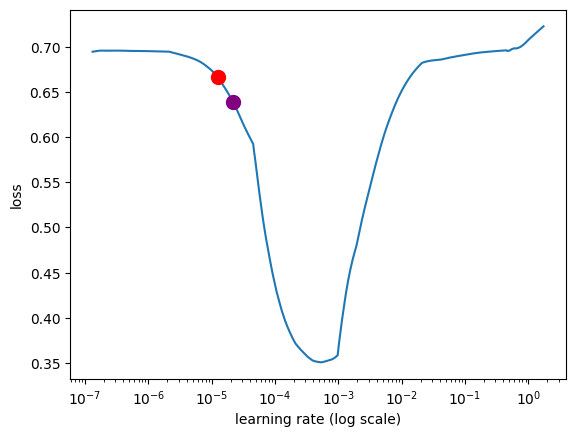

In [17]:
learner.lr_plot(suggest=True)

Now, use the tuned learner to train the best model.

Here, we define a limit of 10 epochs, but in reality, this should stop much sooner due to early stopping.

In [29]:
history=learner.autofit(
    2.15e-5,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 2.15e-05...
Epoch 1/10
113/113 [==============================] - 101s 892ms/step - loss: 0.0962 - accuracy: 0.9722 - val_loss: 0.2729 - val_accuracy: 0.9000
Epoch 2/10
113/113 [==============================] - 102s 900ms/step - loss: 0.0649 - accuracy: 0.9844 - val_loss: 0.3038 - val_accuracy: 0.9100
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


Get the predictor

In [30]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

Optionally, uncomment this code to save the predictor and reload it later. Note, the saved models can be quite large and may quickly use up space on your Google Drive.

In [31]:
predictor.save("drive/MyDrive/MSDSTextClassification_Lab2_2p15e-5.healthy_living")

In [32]:
validation = learner.validate(val_data=val, print_report=True,
                              save_path = "drive/MyDrive/MSDSTextClassification_Lab2.healthy_living_2p15e-5_report")

7/7 [==============================] - 1s 93ms/step
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       104
           1       0.88      0.92      0.90        96

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



---

## 🧐 Lab Quiz Questions 1-4

Enter the following values from the validation report into the Lab Quiz:

 1. precision for non healthy-living articles
 2. recall for non healthy-living articles
 3. precision for healthy-living articles
 4. recall for healthy-living articles

 ---


Keep in mind that we've reduced the training set for the sake of expediency. For your final analysis and project, you should complete a run of the full data set. Pay attention to the impact of the input data on the performance of the final model (i.e. the validation scores)

# Inspecting the drivers of prediction

No matter what the supervised machine learning model, you always want to peak under the hood to see what features are driving prediction. That is, what words sway the outcome of the prediction. It's harder to inspect a neural network. Because all of the layers of a neural network aren't really interpretable to the human eye.

Currently, the best practice I've found is a little tool Explainable AI:
https://alvinntnu.github.io/python-notes/nlp/ktrain-tutorial-explaining-predictions.html

In [23]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

  Preparing metadata (setup.py) ... done


Let's go ahead and make a little set of test documents to check out

In [24]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.'
             ]

In [33]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)

---------------------------
The probability this is healthy is 0.9873799
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is healthy is 0.9700684
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is healthy is 0.42234787
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is healthy is 0.9481242
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is healthy is 0.0046490454
Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The 

*These* are pretty obvious examples, but it works exactly as expected!

In [ ]:
predictor.explain('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.')

/usr/local/lib/python3.10/dist-packages/ktrain/text/predictor.py:147: UserWarning: ktrain requires a forked version of eli5 to support tf.keras. Install with: pip install https://github.com/amaiya/eli5-tf/archive/refs/heads/master.zip
  warnings.warn(msg)


But you can see, this algorithm is far from perfect. Here you can see that it's probably got too high of an emphasis on the word "healthy."

So what would I do next? Well, given that it's over reacting to worrds like health and equitable, I'd try introducing more negative examples into the data, times where healthy is used outside of health and wellness news. We can do this by changing our sample from 50/50 to something like 20/80, but of course, the more documents we process, the longer this model is going to take to make!